# METAR Parsing Support and Declarative Surface Maps

---

### Questions

1. How can MetPy's METAR parser be used to accesss surface observations?
2. How can surface maps be made using MetPy's declarative syntax?

### Objectives
1. <a href="#metarparse">Parse a METAR text file to obtain surface data</a>
1. <a href="#surfacemap">Creating a surface map</a>

<a name="metarparse"></a>
## Parse a METAR text file to obtain surface data

In [1]:
from metpy.io.metar import parse_metar_file
from datetime import datetime
import wget

#### Determine which time to use, download the file, and parse the METARs
Data is from the [Unidata Thredds Test Server](https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.html) which includes data from thirty days in the past to current observations

Another data source is the [Iowa State ASOS Archive](https://mesonet.agron.iastate.edu/request/download.phtml), although there is pre-processing neccessary to determine sky cover and weather symbols

In [2]:
# Select the date 
#time = datetime.utcnow()

# You can also input your own date - be aware that the Thredds test server contains data from past 30 days
time = datetime(2020, 1, 1, 12)

url = time.strftime('https://thredds-test.unidata.ucar.edu/thredds/fileServer/noaaport/text/metar/metar_%Y%m%d_%H00.txt')
file = wget.download(url)
data = parse_metar_file(file)

Convert the temperature and dewpoint from Celsius to Fahrenheit

In [3]:
from metpy.units import units

data['air_temperature']  = (data['air_temperature'].values * units(data.units['air_temperature'])).to('degF')
data['dew_point_temperature'] = (data['dew_point_temperature'].values * units(data.units['dew_point_temperature'])).to('degF')

<a name="surfacemap"></a>
## Creating a surface map

For this plot we need a single panel and we want to plot the surface obs, so we'll use the `PlotObs`.

In [4]:
from metpy.plots import PlotObs, MapPanel, PanelContainer
%matplotlib inline

First, we make the `PlotObs`

In [16]:
# Create the PlotObs object
obs = PlotObs()

# Use the dataframe created previously as the input data
obs.data = data

# Add time
obs.time = time

# Set level to none since data is at surface
obs.level = None

# Specify which fields to plot
obs.fields = ['air_temperature', 'dew_point_temperature', 'air_pressure_at_sea_level', 'cloud_coverage', 'present_weather', 'past_weather']

# Set locations for each variable
obs.locations = ['NW', 'SW', 'NE', 'C', 'W', 'SE']

# Specify format for each variable and utilize weather symbol
obs.formats = [None, None, lambda v: format(10 * v, '.0f')[-3:], 'sky_cover',
               'current_weather', 'current_weather']

# Add colors to each field - if commented out, plot will be black and white
obs.colors = ['red', 'green', 'black', 'black', 'blue', 'blue']

# Plot winds
obs.vector_field = ('eastward_wind', 'northward_wind')

# Reduce the point density
obs.reduce_points = 2

Next, we'll make the panel that our image will go into, the `MapPanel` object and add the image to the plots on the panel.

In [17]:
import cartopy.crs as ccrs

panel = MapPanel()
panel.layout = (1, 1, 1)

# The area which is shown on the plot - states and other regions can be used as well
panel.area = 'uslcc'

# Use a Lambert Conformal Projection
panel.projection = 'lcc'

# Plot coastline, borders, and states
panel.layers = ['coastline', 'borders', 'states']

# Include the PlotObs plot in this panel
panel.plots = [obs]

# Add a title
panel.title = 'Surface Map: Temp(F), Dewp(F), MSLP(hPa), Cloud Cover(Oktas), and Current Weather'

Finally, we make the `PanelContainer` and add the panel to its container 

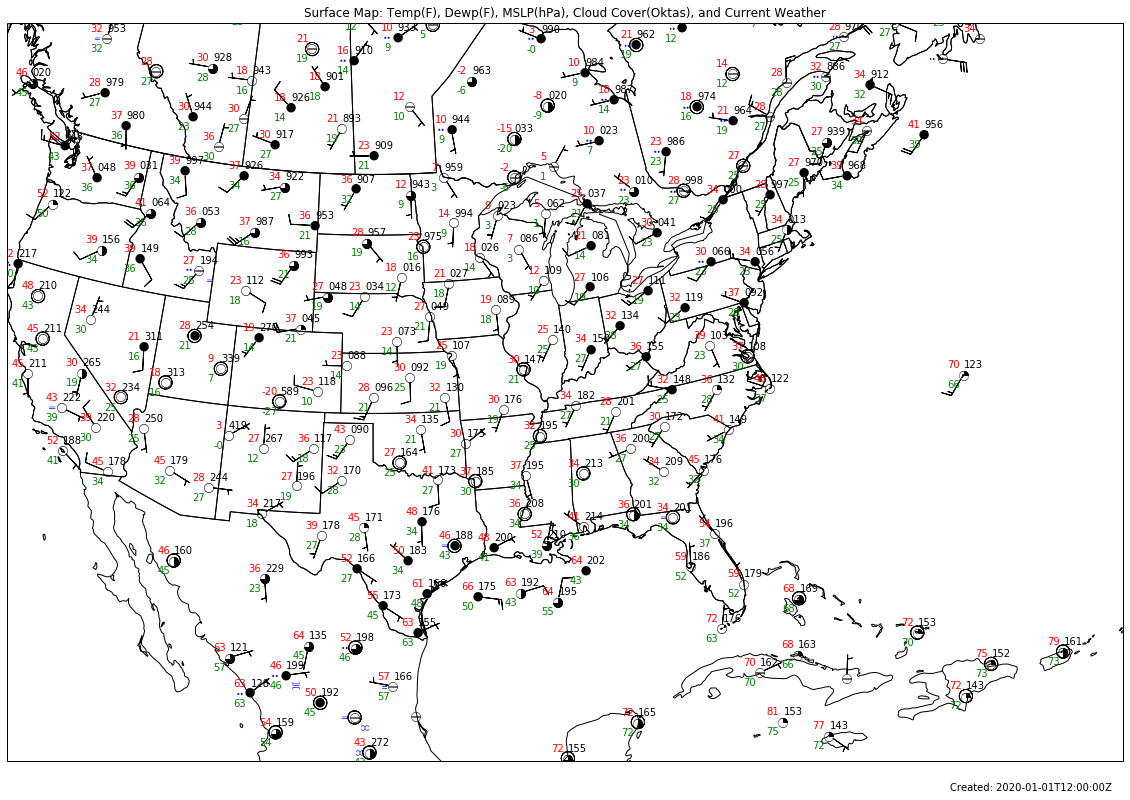

In [18]:
# Collecting panels for complete figure
from metpy.plots import add_timestamp

pc = PanelContainer()
pc.size = (20, 20)
pc.panels = [panel]

# Add a timestamp
add_timestamp(panel.ax, time=time)

pc.show()